# **NLP Project: SkimLit**

In this notebook, we will create an NLP model that can classify sentences which appear in sequential order.

**The model will take an abstract wall of text and predict the section label each sentence should have.**

This is based on a 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

## Input:
Hard to read abstract from PubMed

## Output:
Easier to read abstract

![SkimLit Example](https://camo.githubusercontent.com/685822b9841f09bb871773abdc10c66c3792beb1ec363fb1327c5e90aa695130/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30392d736b696d6c69742d6f766572766965772d696e7075742d616e642d6f75747075742e706e67)

## Problem in a sentence
The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

## Solution in a sentence
Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.



In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ba54cb38-54d3-297e-cfc3-7d1ae54cdcc3)


# Get Data
The authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on [GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


We will start with the `PubMed_20k_RCT_numbers_replaced_with_at_sign`.

## Why?
- To keep experiments short and quick, use smaller dataset.



In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


- `train.txt` - training samples.
- `dev.txt` - validation set.
- `test.txt` - test samples.

In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
#Check filenames in target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Data Preprocessing


In [ ]:
#Function to read lines of a document
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

## 'with' in Python
- with statement is used in exception handling to make the code cleaner and much more readable.

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

The role of each sentence is prefixed at the start of each line separated by a tab (`\t`) and each sentence finishes with a new line (`\n`).

## Steps in Preprocessing
1. Take target file of abstract samples.
2. Read lines of target file.
3. For each line in target file
  - If the line begins with `###` mark it as an abstract ID, i.e. the beginning of a new abstract.
    - Keep count of the number of lines in a sample.
  - If the line begins with \n mark it as the end of an abstract sample.
    - Keep count of the total lines in a sample.

  - Record the text before the \t as the label of the line.

  - Record the text after the \t as the text of the line.

4. Return the lines in the target text file as a list of dictionaries containing key/value pairs.

  - "line_number" - the position of the line in the abstract (e.g. 3).

  - "target" - the role of the line in the abstract (e.g. OBJECTIVE).

  - "text" - the text of the line in the abstract.

  - "total_lines" - the total lines in an abstract sample (e.g. 14).


## Example

[{'**line_number**': 0,

  '**target**': 'OBJECTIVE',

  '**text**': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',

  '**total_lines**': 11},
  ...]

In [ ]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename) #get all lines from the file
  abstract_lines = "" #initialise empty abstract
  abstract_samples = [] #empty list of abstracts

  #Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = "" # reset abstract string

    elif line.isspace(): #If a line is empty or contains only spaces
      abstract_line_split = abstract_lines.splitlines()
      # split abstract into separate lines
      #split on \n

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else:
      #the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 414 ms, sys: 77.1 ms, total: 491 ms
Wall time: 495 ms


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
# change dictionary to pandas dataframe

import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

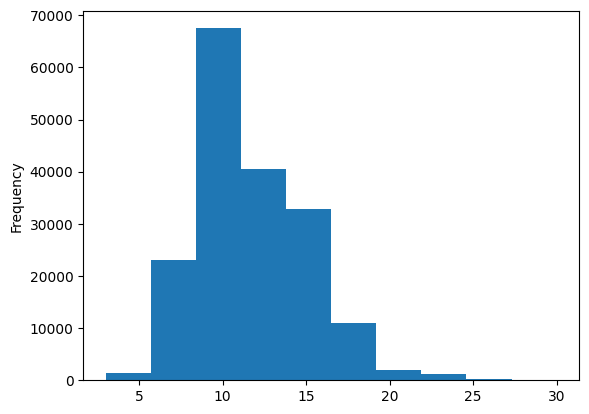

In [ ]:
train_df.total_lines.plot.hist();

## Conclusion
Abstracts are around 7 to 15 sentences in length.

## Get lists of sentences
We can get these easily from our DataFrames by calling the `tolist()` method on our "text" columns.



In [ ]:
#Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Labelling Data
- We will now use **one-hot encoding** to label the data.

- We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

- To numerically encode labels we'll use Scikit-Learn's `OneHotEncoder` and `LabelEncoder` classes.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
len(test_df["target"])

30135

In [ ]:
test_labels_one_hot.shape

(30135, 5)

# Label Encoding
- Apply label encoding to the "target" column of the `train_df` DataFrame using the `fit_transform()` method of the LabelEncoder instance.

- The `fit_transform()` method takes a 1D array-like input (in this case, the "target" column) and returns an array of integers representing the encoded labels.

- The encoded labels are stored in the train_labels_encoded variable.

- Apply the same label encoding transformation to the "target" columns of the val_df and test_df DataFrames using the `transform()` method of the LabelEncoder instance. This ensures that the same encoding scheme is consistently applied to the validation and test datasets.

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Why `.transform()` vs. `fit_transform()`

- **Fit Step (fit):** In this step, the preprocessing instance learns about the data distribution, possible categories, or other necessary information from the provided data (training data).

- **Transform Step (transform):** In this step, the previously learned transformations are applied to new data (validation or test data).

- Once we learned the categories in the training labels, the same labels should apply for the rest. **So no need to fit anymore after the first time**

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Baseline Model

- We will use a **Multinomial Naive Bayes** model as baseline.

- Decision made based on [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

## More Preprocessing: Text Vectorisation
- We'll create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Accuracy of 72%

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

## Evaluating Results

- To evaluate the machine learning model, we use the following
  - Accuracy
  - Precision
  - F1-score
  - Recall

## Download Helper Functions Developed over the Course

In [ ]:
!wget https://raw.githubusercontent.com/sebast0209/NLP/main/helper_functions.py


--2023-08-10 15:27:01--  https://raw.githubusercontent.com/sebast0209/NLP/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10053 (9.8K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   9.82K  --.-KB/s    in 0.001s  

2023-08-10 15:27:01 (16.6 MB/s) - ‘helper_functions.py.1’ saved [10053/10053]



In [ ]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [ ]:
#Calculate baseline result
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Deep Sequence Models

Before we start building deeper models, we've got to create vectorization and embedding layers.

The **vectorization layer** will convert our text to numbers and the **embedding layer** will capture the relationships between those numbers.





In [ ]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

## Prepping the Data
- Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

- When our model goes through our sentences, it works best when they're all the same length (this is **important for creating batches of the same size tensors**).

- For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

In [ ]:
#get average sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

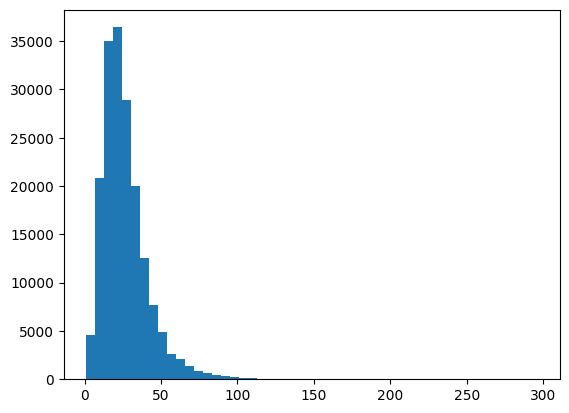

In [ ]:
# Visualise distribution of sentence lengths
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=50);

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

## Interpretation
- **95%** of the sentences in our training set have a **length of 55 tokens or less.**

- we'll use this value to turn all of our sentences into the same length.

- Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated

In [ ]:
# Maximum sentence length in the training set
max(sent_lens)

296

- Since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros

## Text Vectorizer
- We'll keep all the parameters default except for **max_tokens** (the number of unique words in our dataset) and **output_sequence_length** (our *desired output length* for each vectorized sentence).



In [ ]:
# How many words are in our vocabulary?
#(taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
# Text Vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = 55
                                    # desired output length of vectorized sequences
                                    )

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
fatigue vas scores were significantly lower in the cbth group at the end of treatment ( z , @ ; p < @ ) and at the @-month follow-up ( z , @ ; p < @ ) , but not at the @-week follow-up ( p < @ ) .

Length of text: 51

Vectorized text:
[[  648   522   119     9    39   105     5     2 16192    13    15     2
    199     4    19  2129    14     3    15     2   178    94  2129    14
     72    31    15     2    89    94    14     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# Creating a Custom Text Embedding
- Our token_vectorization layer maps the words in our text directly to numbers.

- However, it doesn't necessarily capture the relationships between those numbers.

- To create a richer numerical representation of our text, we will use an **embedding**.

- We can create a trainable embedding layer using TensorFlow's `Embedding` layer.

- The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

- The embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size output_dim.



In [ ]:
#Create embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

#Show example embedding
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
fatigue vas scores were significantly lower in the cbth group at the end of treatment ( z , @ ; p < @ ) and at the @-month follow-up ( z , @ ; p < @ ) , but not at the @-week follow-up ( p < @ ) .

Sentence after vectorization (before embedding):
[[  648   522   119     9    39   105     5     2 16192    13    15     2
    199     4    19  2129    14     3    15     2   178    94  2129    14
     72    31    15     2    89    94    14     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.03734962 -0.02562612  0.04807415 ... -0.02150406  0.03980397
    0.02511697]
  [-0.00226605  0.0185913  -0.02456974 ... -0.03215025  0.00222113
   -0.04029682]
  [-0.00827618 -0.03527623  0.03853853 ... -0.00115835  0.03668337
    0.04822295]
  ...
  [ 0.01502028  0.00554945  0.01503524 ...  0.00226886 -0.02620076
    0.0249348 ]
  [ 0.01502028 

## Creating Datasets (Batching Data)
- The tf.data API provides methods which enable faster data loading.

- The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

- To create a batched PrefetchDataset we can use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.


In [ ]:
#Turn data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with Token Embeddings

- For model 1 we will be using a 1d convolutional neural network.


In [ ]:
#Create 1D CNN model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) #vectorize text inputs
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

#Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

The majority of the trainable parameters are in the Embedding layer. If we increase the size of the embedding (increase `output_dim`), the number of trainable parameters increase.

## Fitting the Model on 10% of the Data
- Why? To make it faster

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))
                              # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 46s 60ms/step - loss: 0.9188 - accuracy: 0.6383 - val_loss: 0.6860 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6552 - accuracy: 0.7607 - val_loss: 0.6372 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6153 - accuracy: 0.7767 - val_loss: 0.5956 - val_accuracy: 0.7812


In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5952 - accuracy: 0.7862


[0.5952178239822388, 0.7862438559532166]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 4ms/step


array([[4.67306107e-01, 1.64651707e-01, 6.79856762e-02, 2.78765917e-01,
        2.12905072e-02],
       [3.78631353e-01, 3.12820792e-01, 1.09995343e-02, 2.83428192e-01,
        1.41200898e-02],
       [1.24763675e-01, 7.24254595e-03, 1.20098051e-03, 8.66737843e-01,
        5.48553908e-05],
       ...,
       [1.17766940e-05, 7.37363938e-04, 9.62347433e-04, 5.48316257e-06,
        9.98283029e-01],
       [5.75046949e-02, 4.74331617e-01, 8.79175738e-02, 6.58420324e-02,
        3.14404070e-01],
       [2.02314302e-01, 6.95497513e-01, 3.74600515e-02, 3.78644317e-02,
        2.68636737e-02]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.62438766053224,
 'precision': 0.7830897443739662,
 'recall': 0.7862438766053224,
 'f1': 0.7838519917593256}

# Model 2: Feature Extraction with **Pretrained** Embeddings

- The [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf) mentions they used a [pretrained `GloVe` embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

- This is known as **feature extraction transfer learning**, as we are taking the patterns a model has learned elsewhere and applying it to our own problem.

In [ ]:
#Download the pretrained embedding from Tensorflow Hub

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")


Random training sentence:
continuous infusion of epoprostenol is the treatment of choice in patients with pulmonary arterial hypertension in functional classes iii to iv .

Sentence after embedding:
[-0.04330089  0.00435759 -0.01653913 -0.00188962  0.01818003 -0.07141153
  0.06557332 -0.04430214  0.01098382 -0.00189546  0.08462597 -0.01527338
  0.04112806  0.07272025  0.00265839 -0.00341632 -0.08467198  0.00186106
 -0.07477591  0.04240195  0.00237724 -0.00550914  0.03923784 -0.07138523
  0.03848856 -0.04618656  0.06784999  0.00910163  0.01064369 -0.0741047 ] (truncated output)...

Length of sentence embedding:
512


In [ ]:
#Define feature extraction model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
#added a layer
outputs = layers.Dense(5,activation="softmax")(x)

model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs)

#Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 14ms/step - loss: 0.9142 - accuracy: 0.6528 - val_loss: 0.7949 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7662 - accuracy: 0.7027 - val_loss: 0.7519 - val_accuracy: 0.7078
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7481 - accuracy: 0.7137 - val_loss: 0.7336 - val_accuracy: 0.7184


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7367 - accuracy: 0.7158


[0.7366679310798645, 0.7158082723617554]

In [ ]:
#Make some predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.2436135e-01, 3.9668739e-01, 2.4349415e-03, 1.6894753e-01,
        7.5687314e-03],
       [3.4687901e-01, 5.1826441e-01, 3.3754546e-03, 1.2868975e-01,
        2.7914229e-03],
       [2.4583392e-01, 1.4137581e-01, 1.7805723e-02, 5.5962247e-01,
        3.5361968e-02],
       ...,
       [1.7256972e-03, 6.5738638e-03, 4.8438318e-02, 7.3614402e-04,
        9.4252592e-01],
       [4.0799687e-03, 4.9132414e-02, 2.3074290e-01, 1.3392952e-03,
        7.1470541e-01],
       [1.5155788e-01, 2.7557811e-01, 5.1050508e-01, 7.2734305e-03,
        5.5085488e-02]], dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.58082880974447,
 'precision': 0.7159516685503994,
 'recall': 0.7158082880974447,
 'f1': 0.7127536273478884}

# Model 3: Conv1D with Charachter Embeddings
- Instead of a token-level embedding, we will instead use a **character-level embedding**.

- This, by itself, will probably not yield much benefits, but we will use it later in a hybrid embedding.



In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)


'c o n t i n u o u s   i n f u s i o n   o f   e p o p r o s t e n o l   i s   t h e   t r e a t m e n t   o f   c h o i c e   i n   p a t i e n t s   w i t h   p u l m o n a r y   a r t e r i a l   h y p e r t e n s i o n   i n   f u n c t i o n a l   c l a s s e s   i i i   t o   i v   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

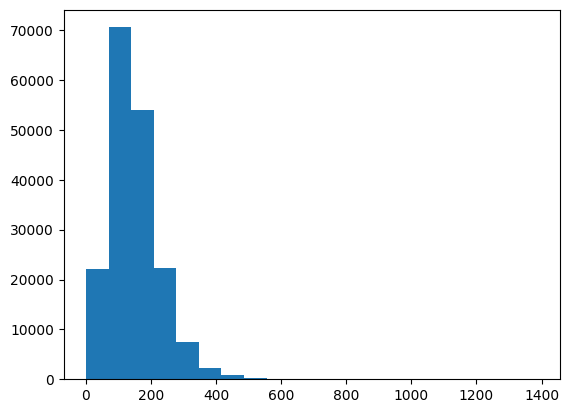

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20);

In [ ]:
#Find the character length that covers 98% of sequences
output_seq_char_len = int(np.percentile(char_lens, 98))
output_seq_char_len

347

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h i s   w a s   a n   a u t o c o n t r o l l e d   c o m p a r i s o n   s t u d y   .

Length of chars: 39

Vectorized chars:
[[ 3 13  4  9 20  5  9  5  6  5 16  3  7 11  7  6  3  8  7 12 12  2 10 11
   7 15 14  5  8  4  9  7  6  9  3 16 10 19  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h i s   w a s   a n   a u t o c o n t r o l l e d   c o m p a r i s o n   s t u d y   .

Embedded chars (after vectorization and embedding):
[[[-0.03117442  0.0314304  -0.04420996 ...  0.01803624  0.03272673
   -0.04190127]
  [-0.03800834 -0.01241872 -0.01984192 ...  0.03166503  0.04031184
   -0.03246083]
  [ 0.00085465 -0.03638528 -0.03037286 ... -0.00264037 -0.03710919
   -0.02465124]
  ...
  [-0.03080252 -0.01091456 -0.01003023 ...  0.04244726  0.02571747
   -0.0209167 ]
  [-0.03080252 -0.01091456 -0.01003023 ...  0.04244726  0.02571747
   -0.0209167 ]
  [-0.03080252 -0.01091456 -0.01003023 ...  0.04244726  0.02571747
   -0.0209167 ]]]

Character embedding shape: (1, 347, 25)


## Building the Model

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 347)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 347, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 347, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 10ms/step - loss: 1.2577 - accuracy: 0.4894 - val_loss: 1.0391 - val_accuracy: 0.5881
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0057 - accuracy: 0.5912 - val_loss: 0.9376 - val_accuracy: 0.6363
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9271 - accuracy: 0.6375 - val_loss: 0.8659 - val_accuracy: 0.6715


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.8872 - accuracy: 0.6574


[0.8872144818305969, 0.6574208736419678]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.17234068, 0.3496543 , 0.09286363, 0.34704414, 0.03809718],
       [0.10091971, 0.7572687 , 0.00845645, 0.0860712 , 0.04728395],
       [0.15282503, 0.48254752, 0.14350101, 0.1863664 , 0.03475995],
       ...,
       [0.02651153, 0.02849074, 0.23487991, 0.04037101, 0.6697468 ],
       [0.02616833, 0.07328292, 0.44945323, 0.02928166, 0.42181388],
       [0.4336038 , 0.39360735, 0.06906113, 0.08863386, 0.01509387]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 0])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.74208923606514,
 'precision': 0.6542718962605005,
 'recall': 0.6574208923606514,
 'f1': 0.6492655396673052}

# Model 4: Hybrid Embedding Layer

- This hybrid token embedding layer is a combination of token embeddings and character embeddings.

Steps to take:
1. Create a token-level model (similar to model_1)

2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)

3. Combine (using layers.Concatenate) the outputs of 1 and 2

4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification]

## `layers.Dropout`
- Dropout works by randomly "dropping out" (i.e., setting to zero) a proportion of the neurons in the layer during each forward and backward pass of training.

- The dropout process introduces noise and prevents the network from becoming overly reliant on specific neurons, helping to prevent overfitting during **training**

> By using dropout, the model is encouraged to learn more robust features that are less dependent on specific neurons. This often leads to improved generalization performance on unseen data.








In [ ]:
# 1. Setup token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_output)

#2. Setup char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 347)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

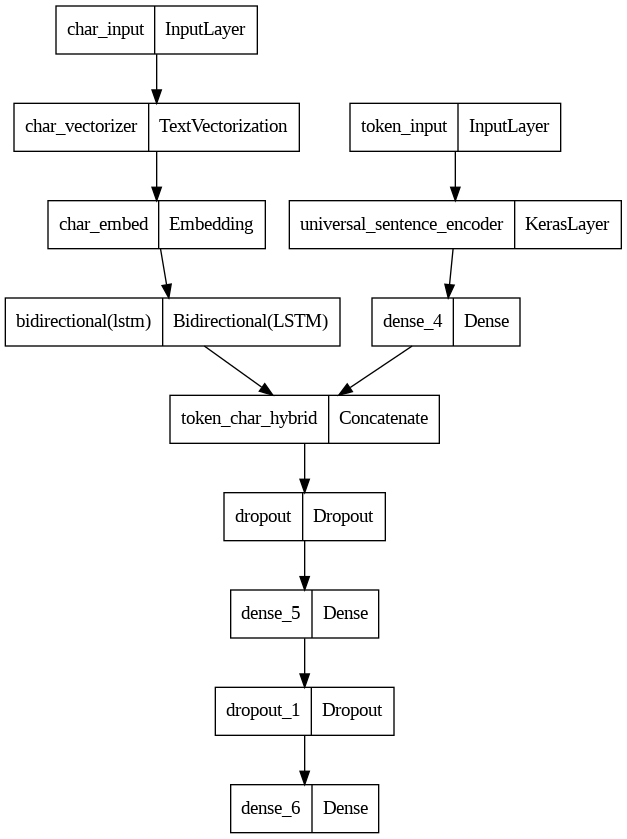

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

## Data Augmentation
This model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a tf.data.Dataset with a tuple as it's first input, for example:

`((token_data, char_data), (label))`

In [ ]:
#Combine chars and tokens into dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
# make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
# make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
# combine data and labels into a single dataset

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
#each batch will contain 32 examples of sentences, character representations, and labels.
# AUTOTUNE dynamically adjusts the number of elements to prefetch based on available resources.

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 37s 52ms/step - loss: 0.9642 - accuracy: 0.6193 - val_loss: 0.7789 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7942 - accuracy: 0.6924 - val_loss: 0.7170 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.7682 - accuracy: 0.7051 - val_loss: 0.6951 - val_accuracy: 0.7370


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6963 - accuracy: 0.7345


[0.6962891817092896, 0.7345094680786133]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 20s 20ms/step


array([[3.6047122e-01, 4.0795034e-01, 5.5345031e-03, 2.1350461e-01,
        1.2539320e-02],
       [3.6391425e-01, 3.9639008e-01, 3.6228024e-03, 2.3255028e-01,
        3.5226760e-03],
       [3.2005888e-01, 1.5575419e-01, 4.7596201e-02, 4.4044536e-01,
        3.6145426e-02],
       ...,
       [6.9348665e-04, 9.1287335e-03, 6.1051916e-02, 3.2761579e-04,
        9.2879832e-01],
       [5.1217126e-03, 5.6673814e-02, 1.8323098e-01, 2.8498729e-03,
        7.5212365e-01],
       [2.7584195e-01, 5.1002544e-01, 1.3843171e-01, 2.9000379e-02,
        4.6700500e-02]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.45094664371773,
 'precision': 0.7354541353652824,
 'recall': 0.7345094664371773,
 'f1': 0.7318618498521465}

# Model 5: Transfer Learning with Hybrid Embedding + Positional Embedding

- The hybrid embedding layer gave a performance boost.

- What if we engineered our own features into the model?

- Meaning, what if we took our own knowledge about the data and encoded it to give our model more information about our samples?

- The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

## Feature Engineering

Notice that sentences usually appear in order!
Abstracts typically come in a sequential order, such as:

- OBJECTIVE ...
- METHODS ...
- METHODS ...
- METHODS ...
- RESULTS ...
- CONCLUSIONS ...

Or

- BACKGROUND ...
- OBJECTIVE ...
- METHODS ...
- METHODS ...
- RESULTS ...
- RESULTS ...
- CONCLUSIONS ...
- CONCLUSIONS ...

When we created our `preprocess_text_with_line_numbers()` function,
we counted the number of lines in an abstract as well as the number of each line itself.



In [ ]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Positional Embeddings
- The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**.

![positional embedding](https://camo.githubusercontent.com/e0c8a2fdb2ca6a1d276b07bd051288ca7c82cc9cdad7713e1fe79a92bf109ce1/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30392d656e67696e65657265642d66656174757265732d61742d746573742d74696d652e706e67)

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

### One-Hot Encoding Line Numbers
- Line numbers should be a **categorical feature** not a numeric one.

- Line 5 is not 5 times Line 1.

- tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

<Axes: ylabel='Frequency'>

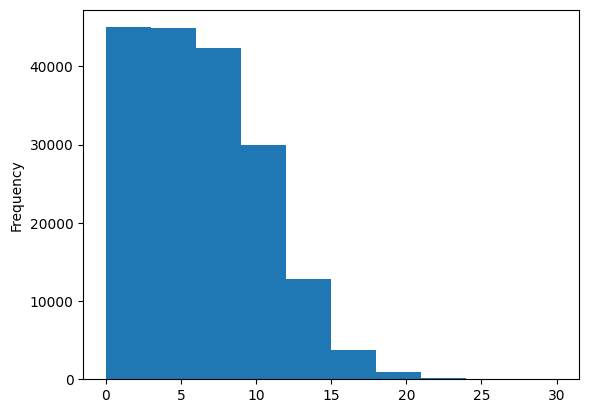

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 20 or less.

Hence, let's **set the depth parameter of tf.one_hot to 20**.



In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=20)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=20)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=20)

In [ ]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

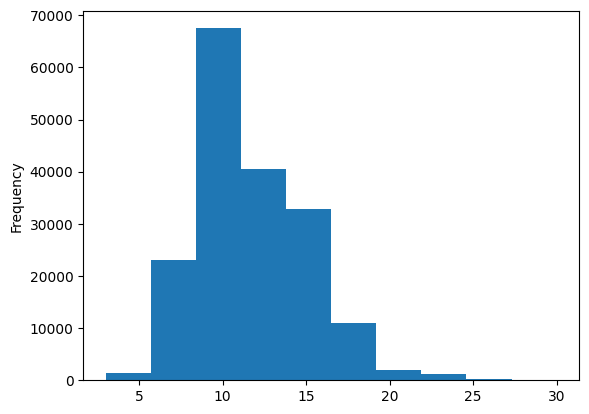

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples


20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Building the TriBid Embedding Model
Steps:
1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. **Combine (using layers.Concatenate) the outputs of 1 and 2 into a **token-character-hybrid embedding and pass it series of output.

6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding

7. Create an output layer to accept the tribrid embedding and output predicted label probabilities

8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`

In [ ]:
#1. Token inputs
token_inputs = layers.Input(shape=[],dtype="string",name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#3. Line number inputs
line_number_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

#4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into
# a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)




In [ ]:
# Get a summary of our token, char and positional embedding model
model_5.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 347)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

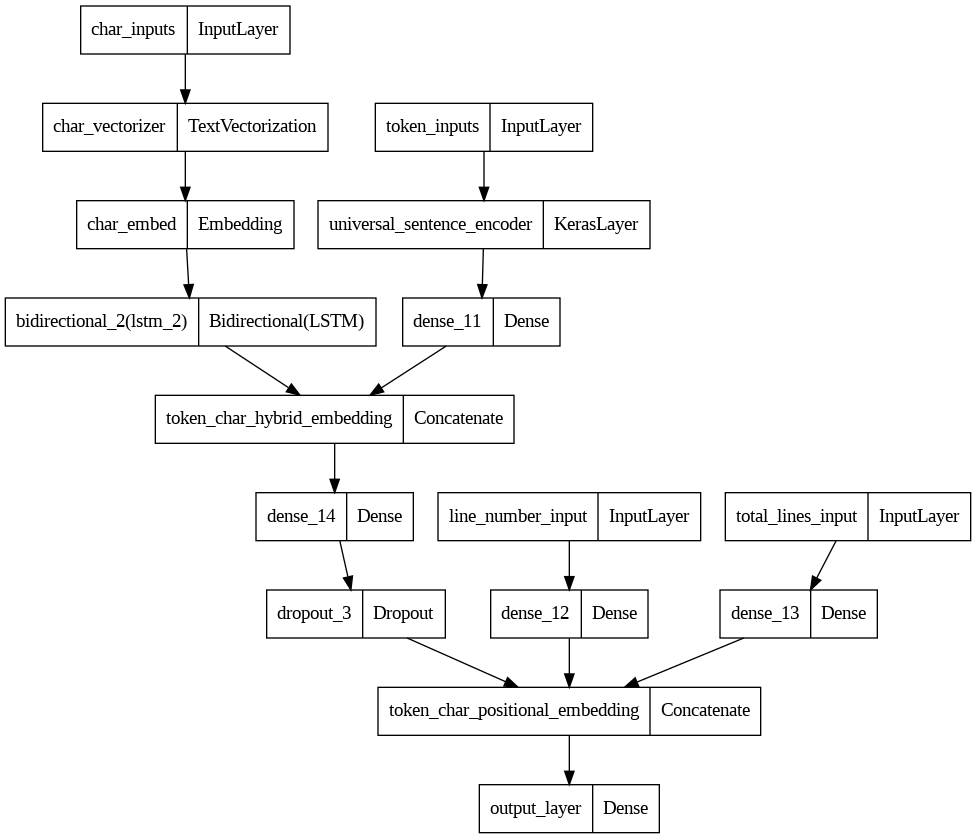

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)


In [ ]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7d319cc37520> True
<keras.engine.input_layer.InputLayer object at 0x7d319cc37b50> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7d31482a31c0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7d3234414490> False
<keras.layers.core.embedding.Embedding object at 0x7d312d638dc0> True
<keras.layers.core.dense.Dense object at 0x7d319cc34550> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7d32a8997880> True
<keras.layers.merging.concatenate.Concatenate object at 0x7d319cd7ff70> True
<keras.engine.input_layer.InputLayer object at 0x7d32a74f2950> True
<keras.engine.input_layer.InputLayer object at 0x7d319cdd5690> True
<keras.layers.core.dense.Dense object at 0x7d31407a71c0> True
<keras.layers.core.dense.Dense object at 0x7d32a8997910> True
<keras.layers.core.dense.Dense object at 0x7d32a8957610> True
<keras.layers.regularization.dropout.Dropout object at 0x7d322057fc70> True
<keras.layers

## Layer Smoothing

- Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

- [0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:

- [0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Customising the Dataset

This time our model requires four feature inputs:

1. Train line numbers one-hot tensor (train_line_numbers_one_hot)
2.Train total lines one-hot tensor (train_total_lines_one_hot)
3. Token-level sequences tensor (train_sentences)
4. Char-level sequences tensor (train_chars)

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                # line numbers
                                                                train_total_lines_one_hot,
                                                                # total lines
                                                                train_sentences,
                                                                # train tokens
                                                                train_chars))
                                                                # train chars

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
# train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
# combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))



Epoch 1/3
562/562 [==============================] - 29s 42ms/step - loss: 1.0955 - accuracy: 0.7215 - val_loss: 0.9810 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.9639 - accuracy: 0.8163 - val_loss: 0.9438 - val_accuracy: 0.8321
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.9475 - accuracy: 0.8266 - val_loss: 0.9372 - val_accuracy: 0.8341


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 26s 27ms/step


array([[0.5035618 , 0.10387395, 0.01211294, 0.36599314, 0.01445814],
       [0.5456307 , 0.09104574, 0.05119025, 0.30202514, 0.01010812],
       [0.28590527, 0.11871464, 0.12325827, 0.40708253, 0.06503934],
       ...,
       [0.03362158, 0.10075566, 0.03831674, 0.02970392, 0.7976021 ],
       [0.03328181, 0.26649928, 0.06488021, 0.02715535, 0.6081833 ],
       [0.20073634, 0.5790199 , 0.12708429, 0.04063123, 0.05252815]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.4569045412419,
 'precision': 0.8335913541693146,
 'recall': 0.8345690454124189,
 'f1': 0.8333417959992062}

# Comparing Models
Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.624388,0.783090,0.786244,0.783852
pretrained_token_embed,71.580829,0.715952,0.715808,0.712754
custom_char_embed_conv1d,65.742089,0.654272,0.657421,0.649266
hybrid_char_token_embed,73.450947,0.735454,0.734509,0.731862
tribrid_pos_char_token_embed,83.456905,0.833591,0.834569,0.833342


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

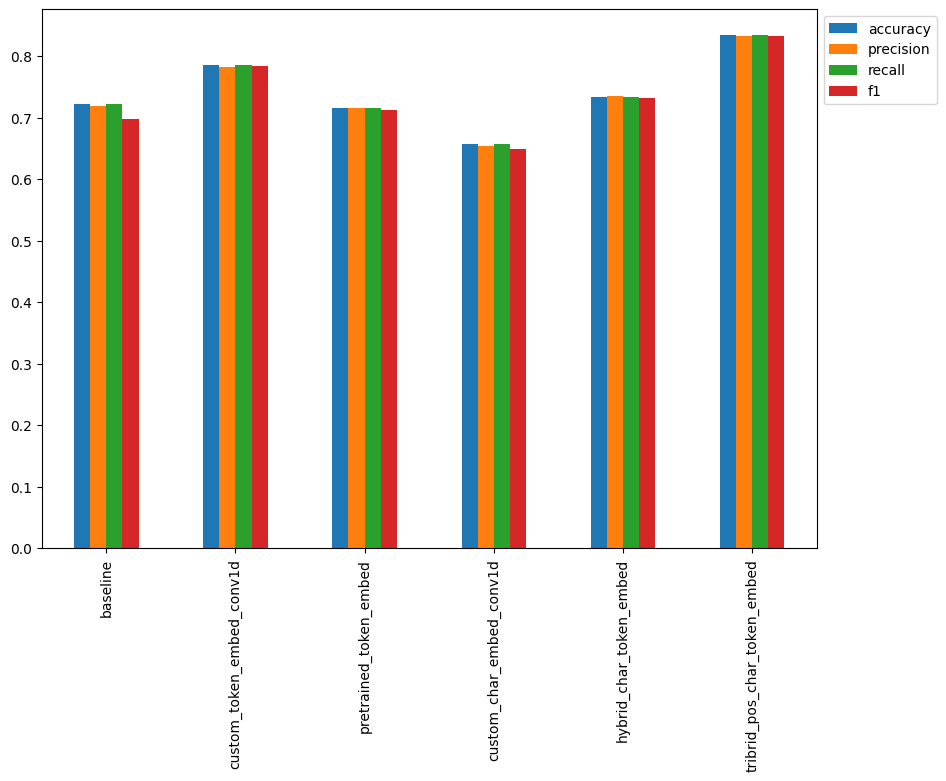

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

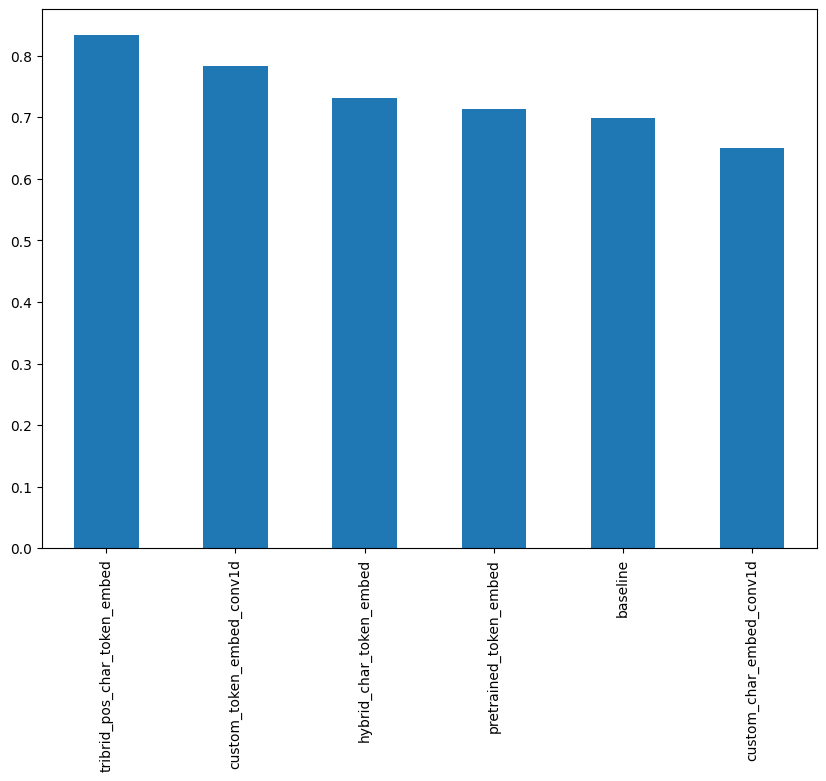

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Comparing with PubMed
- In comparison to the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0)

Justification:
1. Our model was only trained on 10% of the data.

2. Our model's prediction performance levels have been evaluated on the validation dataset not the test dataset


In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string


In [ ]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")#,


In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 22s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.4569045412419,
 'precision': 0.8335913541693146,
 'recall': 0.8345690454124189,
 'f1': 0.8333417959992062}

In [ ]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [ ]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 347)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

# Evaluating Model on Test Data


In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 26s 27ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.9732868757259,
 'precision': 0.828311943570531,
 'recall': 0.829732868757259,
 'f1': 0.8285241734478472}

# The Most Wrong Results
- The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 16.3 s, sys: 734 ms, total: 17.1 s
Wall time: 16.6 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',


## Data Enrichment
We will enrich the dataframe with the following fields:

- A "**prediction**" (string) column containing our model's prediction for a given sample.

- A "**pred_prob**" (float) column containing the model's maximum prediction probabiliy for a given sample.

- A "**correct**" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.464396,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.319823,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.785829,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.620613,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.709286,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.857715,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.569538,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.522720,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.504232,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.572430,True


In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.952479,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.943272,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.939663,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.929842,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.927447,False
...,...,...,...,...,...,...,...
24826,OBJECTIVE,", group c ( @ pts . )",4,11,METHODS,0.836711,False
137,CONCLUSIONS,"compared to group s , there was a transient im...",8,8,RESULTS,0.836488,False
16706,RESULTS,the effects of the two acupuncture techniques ...,15,18,CONCLUSIONS,0.835791,False
18002,RESULTS,application of loperamide hcl in a liposomal g...,11,20,CONCLUSIONS,0.835575,False


In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9524787664413452, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9432719349861145, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.939662754535675, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.929842472076416, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9274470210075378, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: BACKGROUND, Prob: 0.9250223636627197, Line number: 8, Total lines: 15

Text:
non-diffuse-trickling '' ) .

-----

Target: CONCLUSIONS, Pred:

- Noticed some mislabelled data. For example the last one:

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9119065999984741, Line number: 4, Total lines: 27

Text:
second , we collected patient-reported outcomes for balance confidence and falls control .
